# Semeval 2025 Task 10
### Subtask 1: Entity Framing

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a predefined taxonomy of fine-grained roles covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

## 1. Importing libraries

In [1]:
# Instructor compatible with these versions only
!pip install -q huggingface_hub==0.23.5
!pip install -q langchain==0.1.2 sentence_transformers==2.2.2

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os


In [3]:
!pip install InstructorEmbedding

## 2. Reading our data


We will go ahead and start by reading the annotations from the subtask-1.

* The annotations are our ground-truths.
For each article we read it's id, it's entity which is by-default given to us, and the class/sub-class where it belongs to.

In [4]:
raw_annotation_data = []

with open("data/semeval_data/subtask-1-annotations.txt", 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        article_id = parts[0]
        entity_mention = parts[1]
        start_offset = int(parts[2])
        end_offset = int(parts[3])
        main_role = parts[4]
        
        sub_roles = parts[5:] 
        raw_annotation_data.append({
            "article_id": article_id,
            "entity_mention": entity_mention,
            "start_offset": start_offset,
            "end_offset": end_offset,
            "main_role": main_role,
            "sub_roles": sub_roles
        })

annotations_df = pd.DataFrame(raw_annotation_data)

In [5]:
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,sub_roles
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,[Spy]
1,EN_UA_103861.txt,China,1516,1520,Antagonist,[Instigator]
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,[Terrorist]
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,"[Peacemaker, Guardian]"
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,[Incompetent]


In [6]:
annotations_df.shape

(414, 6)

For simplicity, we will ignore the `fine-grained_roles` attribute for, as it requires further thinking on how to handle a specific article on having multiple roles.

For now, we will focus on trying to classify each entity on it's `main_role` and then move from there.

Notice that in a single article, we can have the same entity mentioned playing different roles:

In [7]:
annotations_df[annotations_df['article_id'] == 'EN_UA_013257.txt']

,article_id,entity_mention,start_offset,end_offset,main_role,sub_roles
398,EN_UA_013257.txt,Russia,375,380,Protagonist,[Underdog]
399,EN_UA_013257.txt,Russia,944,949,Innocent,[Victim]
400,EN_UA_013257.txt,Russia,1590,1595,Protagonist,[Guardian]
401,EN_UA_013257.txt,Western countries,1667,1683,Antagonist,[Saboteur]
402,EN_UA_013257.txt,Russia,1763,1768,Protagonist,[Virtuous]


Also, notice that in the `article_id` the beginning of it, the `EN_*` part, is irrelevant to us.

We will go ahead and remove it and only keep the id of the article which is the part we actually want.

In [8]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [9]:
annotations_df['article_id'] = annotations_df['article_id'].apply(extract_article_id)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,sub_roles
0,103861,Chinese,791,797,Antagonist,[Spy]
1,103861,China,1516,1520,Antagonist,[Instigator]
2,103861,Hamas,2121,2125,Antagonist,[Terrorist]
3,103861,Donald Trump,4909,4920,Protagonist,"[Peacemaker, Guardian]"
4,021270,Yermak,667,672,Antagonist,[Incompetent]


We will know read our actual articles.

In [10]:
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


We create a placeholder dataframe, that is going to be filled up.

There are 2 columns that we are seeking, the `article_id` and the actual `content` of that.

In [11]:
documents_df = pd.DataFrame(columns=['article_id', 'content'])

In [12]:
folder_path = "data/semeval_data/raw-documents"

for filename in os.listdir(folder_path):
    if filename.endswith('.txt') and filename.startswith('EN'):
        article_id = extract_article_id(filename)
        file_path = os.path.join(folder_path, filename)
        content = read_file_content(file_path)

        new_row = pd.DataFrame({'article_id': [article_id], 'content': [content]})

        documents_df = pd.concat([documents_df, new_row], ignore_index=True)

documents_df.head()

,article_id,content
0,104876,Putin honours army unit blamed for Bucha massa...
1,023211,Europe Putin thanks US journalist Tucker Carls...
2,011260,Russia has a clear plan to resolve the conflic...
3,101067,"First war of TikTok era sees tragedy, humor an..."
4,102963,Ukraine's President Zelenskyy to address Mexic...


There are 200 articles that are given to us for this task:

In [13]:
documents_df.shape

(200, 2)

We then merge our dataframes into a single dataframe constisting.

The derived dataframe has the following columns:

* `article_id`
* `content`
* `entity_mention`
* The entity's starting and ending position in the article
* The ground truth of the entity.

In [14]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant]
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian]
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]"
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker]
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]"


In [15]:
print(dataset.iloc[4].content)

Russia has a clear plan to resolve the conflict in Ukraine 

 The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals.

"An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia's Ambassador to the UN Security Council, said at a briefing at the UN Security Council.

"If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added.

Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in 2014” after the coup in Kyiv, the diplomat said.

"The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…>

"The Kyiv regime and its most rabid patrons hav

Since the annotations where limited to `417`, we also expect that the merged dataframe will be of that size:

In [16]:
dataset.shape

(417, 7)

We also do a sanity-check to see if there are any missing values:

In [17]:
dataset.isnull().sum()

article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
sub_roles         0
dtype: int64

Notice that the distributions of roles are uneven, with the `Antagonist` being the most common class, and `Innocent` being the least common.

This should worry us, and we should keep this in mind when attempting to find a good classifier.

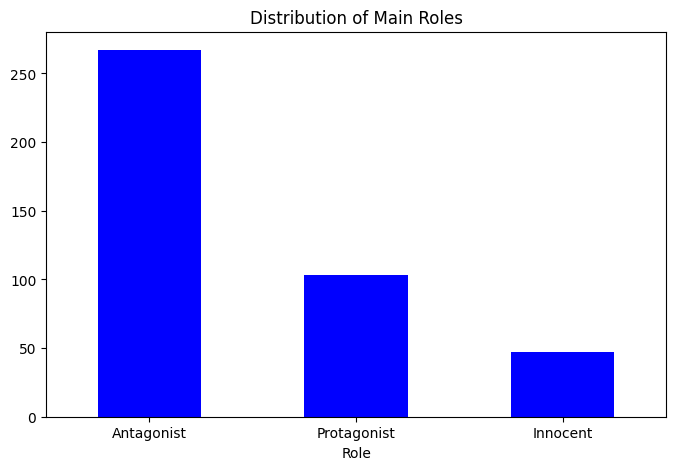

In [18]:
role_counts = dataset['main_role'].value_counts()

plt.figure(figsize=(8, 5))
role_counts.plot(kind='bar', color=['blue'])
plt.title('Distribution of Main Roles')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.show()

## 3. Preparing our data

We now begin by processing our data and preparing it in order to find a good, initial/baseline classifier for this task.


Our goal is to classify those entities into 3 classes:
* `Protagonist`
* `Antagonist`
* `Innocent`

It's obvious that this task is an instance of a supervised learning, we have some features and we are also given the ground truth, the class where each entity truly belongs to.

We begin by shuffling our data:

In [19]:
print(dataset.iloc[1].content)

Putin honours army unit blamed for Bucha massacre with award for ‘heroism and bravery’ 

 VLADIMIR Putin has honoured an army unit accused of war crimes and genocide in the Russian town of Bucha, reports suggest.

A decree signed by the Russian tyrant gave the 64th Motor Rifle Brigade the title of guards – scandalously praising them for "mass heroism and valour, tenacity and courage."

Earlier this month, the Ukrainian ministry identified the unit as those responsible for the alleged rape and murder of innocent Ukrainians.

The barbarous pack, headed by Lieutenant Colonel Azatbek Omurbekov - dubbed the “Butcher of Bucha” - left a trail of death and destruction in their wake.

Harrowing pictures from the city, to the north-west of the capital Kyiv, showed the bodies of civilians scattered in the road and in shallow graves — many with bound hands and signs of torture.

Some of them, from the wounds they had suffered, had been shot from close range.

READ MORE ON UKRAINE

Heavily mutilate

### 3.1 Training a baseline model

We will begin by seeing how good of a job traditional machine learning models can do for this kind of tasks.

Our idea is simple, since we have the `start_offset` and `end_offset` of each entity, we can also get the nearby x words of that entity surrounding it, before and after:

In [20]:
def get_context(row, window=150):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [21]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [22]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

The article in row 1, has the entity mentioned:

In [23]:
dataset.iloc[1].entity_mention

'President Volodymyr Zelensky'

Context before the entity:

In [24]:
dataset.iloc[1].context_before

'a bullet in the head and chest as evidence of alleged torture chambers emerged online. Women and children were also found by Ukrainian soldiers, having been raped and then murdered. Most read in News The barbaric troops are believed to have conducted the Bucha slaughter as they scarpered from Kyiv after their botched attempt to take the Ukrainian capital. Days later, Ukrainian intelligence suggested the troops were being redeployed in Belgorod in Western Russia amid claims that Russian commanders were refusing to rotate their brigades. The country’s defence ministry claimed troops were being sent to the "hottest spots" in the hope they will be slaughtered by Ukrainian fighters before they can testify before a war crime tribunal. The Kremlin has continued to deny accusations its troops committed war crimes in Ukraine after suggesting chilling pictures of dead bodies strewn across Kyiv streets were staged by Ukraine and the West. Heroic'

Context after the entity:

In [25]:
dataset.iloc[1].context_after

"was visibly emotional as he visited the site just days after the mass graves were discovered. The Ukrainian leader was flanked by security as he vowed to ensure that the “war crimes” committed by Russian soldiers on his country’s soil were “the last such evil on Earth”. Boris Johnson later described the events as not “far short of genocide” as the EU's Ursula von der Leyen was later seen visiting the scene of the massacre. It comes as the number of heads of state and former prime ministers backing calls for an international tribunal over Ukraine continues to rise amid widespread international condemnation of the events unfolding in Eastern Europe. READ MORE SUN STORIES Read More on The Sun The Butcher is now at the centre of a probe into the rape, pillage and murder of hundreds of Ukrainians. International law states a military commander is responsible for any war"

In [26]:
dataset.iloc[1].main_role

'Protagonist'

We also do again a sanity check that our results are correct:

In [27]:
dataset.iloc[1].content

'Putin honours army unit blamed for Bucha massacre with award for ‘heroism and bravery’ \n\n VLADIMIR Putin has honoured an army unit accused of war crimes and genocide in the Russian town of Bucha, reports suggest.\n\nA decree signed by the Russian tyrant gave the 64th Motor Rifle Brigade the title of guards – scandalously praising them for "mass heroism and valour, tenacity and courage."\n\nEarlier this month, the Ukrainian ministry identified the unit as those responsible for the alleged rape and murder of innocent Ukrainians.\n\nThe barbarous pack, headed by Lieutenant Colonel Azatbek Omurbekov - dubbed the “Butcher of Bucha” - left a trail of death and destruction in their wake.\n\nHarrowing pictures from the city, to the north-west of the capital Kyiv, showed the bodies of civilians scattered in the road and in shallow graves — many with bound hands and signs of torture.\n\nSome of them, from the wounds they had suffered, had been shot from close range.\n\nREAD MORE ON UKRAINE\n\

We then combine the ccontext before and after the entity to a single, `entity_context`.

In [28]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [29]:
dataset.drop(columns=['context_before', 'context_after'], inplace=True)
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant],Putin honours army unit blamed for Bucha massa...
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian],a bullet in the head and chest as evidence of ...
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]",Russia has a clear plan to resolve the conflic...
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker],Russia has a clear plan to resolve the conflic...
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]",Russia has a clear plan to resolve the conflic...


In [30]:
dataset.iloc[1].entity_context

'a bullet in the head and chest as evidence of alleged torture chambers emerged online. Women and children were also found by Ukrainian soldiers, having been raped and then murdered. Most read in News The barbaric troops are believed to have conducted the Bucha slaughter as they scarpered from Kyiv after their botched attempt to take the Ukrainian capital. Days later, Ukrainian intelligence suggested the troops were being redeployed in Belgorod in Western Russia amid claims that Russian commanders were refusing to rotate their brigades. The country’s defence ministry claimed troops were being sent to the "hottest spots" in the hope they will be slaughtered by Ukrainian fighters before they can testify before a war crime tribunal. The Kremlin has continued to deny accusations its troops committed war crimes in Ukraine after suggesting chilling pictures of dead bodies strewn across Kyiv streets were staged by Ukraine and the West. Heroic President Volodymyr Zelensky was visibly emotional

In [31]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant],Putin honours army unit blamed for Bucha massa...
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian],a bullet in the head and chest as evidence of ...
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]",Russia has a clear plan to resolve the conflic...
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker],Russia has a clear plan to resolve the conflic...
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]",Russia has a clear plan to resolve the conflic...


In [32]:
!pip install emoji

In [33]:
import spacy
import re
import emoji

nlp = spacy.load("en_core_web_sm")

def clean_article(article_text):
    # Remove URLs
    article_text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com', '', article_text, flags=re.MULTILINE)

    doc = nlp(article_text)
    cleaned_tokens = []

    for token in doc:
        if token.is_space or '@' in token.text or emoji.is_emoji(token.text) or token.like_num:
            continue

        cleaned_tokens.append(token.text + token.whitespace_)

    cleaned_article = "".join(cleaned_tokens).strip()

    return cleaned_article

In [34]:
dataset['entity_context'] = dataset['entity_context'].apply(clean_article)
dataset.iloc[3].entity_context

'Russia has a clear plan to resolve the conflict in Ukraine The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals. "An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia\'s Ambassador to the UN Security Council, said at a briefing at the UN Security Council. "If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added. Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in ” after the coup in Kyiv, the diplomat said. "The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…> "The Kyiv regime and its most rabid patrons have forgotte

In [35]:
dataset.iloc[1].entity_context

'a bullet in the head and chest as evidence of alleged torture chambers emerged online. Women and children were also found by Ukrainian soldiers, having been raped and then murdered. Most read in News The barbaric troops are believed to have conducted the Bucha slaughter as they scarpered from Kyiv after their botched attempt to take the Ukrainian capital. Days later, Ukrainian intelligence suggested the troops were being redeployed in Belgorod in Western Russia amid claims that Russian commanders were refusing to rotate their brigades. The country’s defence ministry claimed troops were being sent to the "hottest spots" in the hope they will be slaughtered by Ukrainian fighters before they can testify before a war crime tribunal. The Kremlin has continued to deny accusations its troops committed war crimes in Ukraine after suggesting chilling pictures of dead bodies strewn across Kyiv streets were staged by Ukraine and the West. Heroic President Volodymyr Zelensky was visibly emotional

In [36]:
dataset.iloc[3]

article_id                                                   011260
content           Russia has a clear plan to resolve the conflic...
entity_mention                                               Russia
start_offset                                                    637
end_offset                                                      642
main_role                                               Protagonist
sub_roles                                              [Peacemaker]
entity_context    Russia has a clear plan to resolve the conflic...
Name: 3, dtype: object

In [37]:
dataset['entity_context'].iloc[4]

'Russia has a clear plan to resolve the conflict in Ukraine The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals. "An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia\'s Ambassador to the UN Security Council, said at a briefing at the UN Security Council. "If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added. Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in ” after the coup in Kyiv, the diplomat said. "The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…> "The Kyiv regime and its most rabid patrons have forgotte

In [38]:
dataset['main_role'].iloc[4]

'Antagonist'

In [39]:
dataset['entity_mention'].iloc[4]

'Ukrainian leadership'

In [40]:
from sklearn.preprocessing import LabelEncoder

_le = LabelEncoder()
dataset['main_role_encoded'] = _le.fit_transform(dataset['main_role'])

In [41]:
dataset['main_role_encoded']

0      0
1      2
2      0
3      2
4      0
      ..
412    0
413    0
414    0
415    2
416    0
Name: main_role_encoded, Length: 417, dtype: int64

In [42]:
embeddings_dir = 'data/embeddings/entity_framing/'
embedding_file_name = 'all_embeddings.npy'
embeddings_full_path = embeddings_dir + embedding_file_name

In [43]:
import os

def are_embeddings_saved(filepath):
    if os.path.exists(filepath):
        return True
    return False

In [44]:
from InstructorEmbedding import INSTRUCTOR
model = INSTRUCTOR('hkunlp/instructor-large')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the 

In [45]:
def precompute_embeddings(dataset, model, file_path):
    embeddings = []
    for index, row in dataset.iterrows():
        entity = row['entity_mention']
        context = row['entity_context']
        instruction = f"Classify the role of {entity} in this context as antagonist, protagonist, or innocent. Pay attention to {entity}'s actions, sentiment, and surrounding context."
        embedding = model.encode([[instruction, context]])
        embeddings.append(embedding[0])

    embeddings_array = np.array(embeddings)
    np.save(file_path, embeddings_array)
    print(f"Embeddings saved to {file_path}")

def load_embeddings(filename):
    return np.load(filename)

if not are_embeddings_saved(embeddings_full_path): precompute_embeddings(dataset, model, embeddings_full_path)

In [46]:
from sklearn.model_selection import train_test_split

all_embeddings = load_embeddings(embeddings_full_path)

train_indices, temp_indices = train_test_split(np.arange(all_embeddings.shape[0]), 
                                            train_size=0.85, 
                                            shuffle=True, 
                                            stratify=dataset['main_role_encoded'])
    
val_indices, test_indices = train_test_split(temp_indices, 
                                            train_size=0.5, 
                                            shuffle=True, 
                                            stratify=dataset.loc[temp_indices, 'main_role_encoded'])

train_x_embeddings = all_embeddings[train_indices]
val_x_embeddings = all_embeddings[val_indices]
test_x_embeddings = all_embeddings[test_indices]
    
train_y_encoded = dataset['main_role_encoded'].iloc[train_indices]
val_y_encoded = dataset['main_role_encoded'].iloc[val_indices]
test_y_encoded = dataset['main_role_encoded'].iloc[test_indices]

In [47]:
for i in range(0, 5):
    print(train_x_embeddings[i][:5])
    print(train_y_encoded.iloc[i])

[-0.02513161 -0.03682485 -0.03942177  0.02195845  0.06784622]
2
[-0.00981346 -0.00728108 -0.02124609  0.02822829  0.0809826 ]
0
[-0.01940481 -0.01416501 -0.00814522  0.02558444  0.08832315]
0
[-0.04174675  0.00029864 -0.01103903  0.01594476  0.06895804]
0
[-0.01408361 -0.0240064  -0.04587442  0.02951967  0.09154292]
2


In [48]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [50]:
print(model)

INSTRUCTOR(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Dense({'in_features': 1024, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (3): Normalize()
)


In [51]:
import random

def get_sentence_and_target_for_class(_class):
    filtered_dataset = dataset[dataset['main_role'] == _class]
    
    if filtered_dataset.empty:
        raise ValueError(f"No entries found for class {_class}")
    
    random_index = random.randint(0, len(filtered_dataset) - 1)
    row = filtered_dataset.iloc[random_index]
    
    sentence_class = row.entity_context
    sentence_target = row.entity_mention
    
    return sentence_class, sentence_target


sentence_antag1, target_antag1 = get_sentence_and_target_for_class("Antagonist")
print(sentence_antag1)
print('\n')
print(target_antag1)

city centre. Troops attacked the Retroville mall just outside Kyiv in the Podilskyi district, killing civilians. In the north of the country, Russian troops are attempting to surround the city of Sumy. Many civilians have joined Ukrainian forces in the fight for their homeland. RUSSIA LATEST Which parts of Ukraine has Russia invaded? Russia has made large sweeps in the south of Ukraine, using Crimea and the separatist supporters in Donetsk and Luhansk. Troops moved into the Kherson region from Crimea - a territory that Russia annexed from Ukraine in . Kherson and Melitopol areas of Ukraine are under control of Russian forces. There is strong Russian presence in Chernobyl and the surrounding area. Northern cities of Chernihiv and Konotop, which are closest to the Russian and Belarusian borders, have also been taken. Read our Russia - Ukraine live blog for the very latest updates Why has R Russia invaded Ukraine? Unrest in the Donbas region began in after the Russian annexation of Crimea

In [52]:
sentence_antag2, target_antag2 = get_sentence_and_target_for_class("Antagonist")

print(sentence_antag2)
print('\n')
print(target_antag2)

Russian counterparts under Communism. Criticizing Soviet society was a serious crime in those days, but I doubt that the Russians ever considered arresting Nixon and giving him a year stretch in the gulag for “anti-Soviet agitation.” Not even Maoist China at the height of its Cultural Revolution would have considered such a thing. TRUTH LIVES on at But late last week, on the eve of a Russia-China leadership summit in Moscow, Europe’s International Criminal Court (ICC) in the Hague issued an arrest warrant for Russian President Vladimir Putin, the man who controls the world’s largest nuclear arsenal, whose striking power is further enhanced by its revolutionary hypersonic delivery systems. The charges against Putin were that he had ordered the humanitarian evacuation of children from the dangerous Ukraine warzone, and the ICC also ordered the arrest of Maria Lvova-Belova, the Russian Commissioner for Children’s Rights. Yet oddly enough, no ICC action had ever been taken against American

In [53]:
instruction = "Classify the role of {entity} in this context as antagonist, protagonist, or innocent. Pay attention to {entity}'s actions, sentiment, and surrounding context."

instruction1 = instruction.format(entity=target_antag1)
instruction2 = instruction.format(entity=target_antag2)
print(instruction1)
print(instruction2)

embedding1 = model.encode([instruction1, sentence_antag1])[0]
embedding2 = model.encode([instruction2, sentence_antag2])[0]

Classify the role of Russia in this context as antagonist, protagonist, or innocent. Pay attention to Russia's actions, sentiment, and surrounding context.
Classify the role of ICC in this context as antagonist, protagonist, or innocent. Pay attention to ICC's actions, sentiment, and surrounding context.


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity([embedding1], [embedding2])
print(cosine_sim)

[[0.93504125]]


In [55]:
sentence_innocent1, target_innocent1 = get_sentence_and_target_for_class("Innocent")

print(sentence_innocent1)
print('\n')
print(target_innocent1)

Israel turns down Zelensky request to make solidarity visit; 'it's not the right time' Ukrainian President Volodymyr Zelensky, who visited European countries last week, wanted to make a solidarity visit to Israel alongside U.S. Secretary of State Antony Blinken, but was turned down by Israel. More stories: According to sources familiar with the request, Israel informed the Jewish leader that "it's not the right time", but he might visit later. Zelensky wishes to express support for Israel, but due to his own constraints - as Ukraine has been under attack from Russia for nearly years - he cannot make it to Israel on a "standalone trip" and is expected to include Israel as part of a future European tour. Meanwhile, the Ukrainian police, spanning its many units including the special forces, crafted a heartfelt tribute to the State of Israel through a video featuring officers from across their ranks. "The year is . Israel was brutally attacked by terrorists. During the attack, hundreds of 

In [56]:
instruction3 = instruction.format(entity=target_innocent1)

embedding3 = model.encode([instruction3, sentence_innocent1])[0]

In [57]:
cosine_sim = cosine_similarity([embedding1], [embedding3])
print(cosine_sim)

[[0.9690192]]


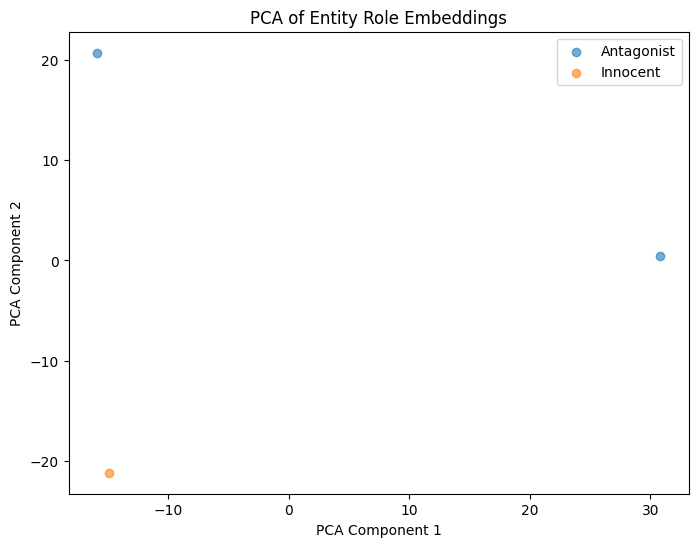

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

embeddings = np.array([embedding1, embedding2, embedding3])
labels = np.array(['Antagonist', 'Antagonist', 'Innocent']) 

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_scaled)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=label, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Entity Role Embeddings')
plt.legend()
plt.show()

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.46804391 0.48582959 0.385195  ]
Mean CV F1 Score: 0.44635616321312505


              precision    recall  f1-score    support
0              0.695652  0.800000  0.744186  20.000000
1              0.333333  0.333333  0.333333   3.000000
2              0.600000  0.375000  0.461538   8.000000
accuracy       0.645161  0.645161  0.645161   0.645161
macro avg      0.542995  0.502778  0.513019  31.000000
weighted avg   0.635905  0.645161  0.631485  31.000000




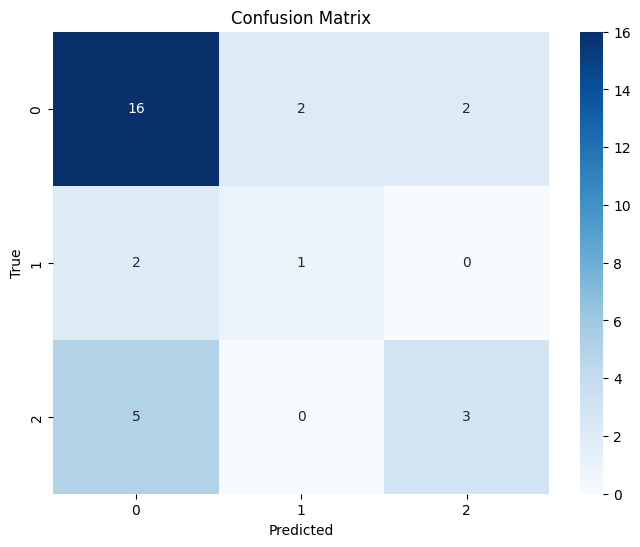

array([[16,  2,  2],
       [ 2,  1,  0],
       [ 5,  0,  3]])

In [60]:
knn_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(knn_classifier, val_x_embeddings, val_y_encoded)

In [61]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.44201413 0.362223   0.41587302]
Mean CV F1 Score: 0.4067033792682757


              precision    recall  f1-score    support
0              0.692308  0.900000  0.782609  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.750000  0.375000  0.500000   8.000000
accuracy       0.677419  0.677419  0.677419   0.677419
macro avg      0.480769  0.425000  0.427536  31.000000
weighted avg   0.640199  0.677419  0.633941  31.000000




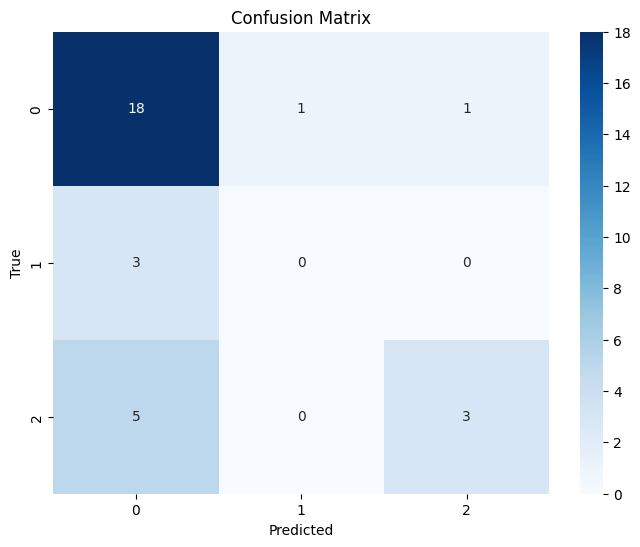

array([[18,  1,  1],
       [ 3,  0,  0],
       [ 5,  0,  3]])

In [62]:
xgb_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(xgb_classifier, val_x_embeddings, val_y_encoded)

In [63]:
label = _le.inverse_transform([1])
print(label)

['Innocent']


In [64]:
from collections import Counter
Counter(train_y_encoded)

Counter({0: 227, 2: 87, 1: 40})

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, learning_rate=.1)

get_cross_val_score(adaboost_classifier, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.42364401 0.40642886 0.3823075 ]
Mean CV F1 Score: 0.40412678873656344


In [66]:
adaboost_classifier.fit(train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=100)

              precision    recall  f1-score    support
0              0.727273  0.800000  0.761905  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.571429  0.500000  0.533333   8.000000
accuracy       0.645161  0.645161  0.645161   0.645161
macro avg      0.432900  0.433333  0.431746  31.000000
weighted avg   0.616674  0.645161  0.629186  31.000000




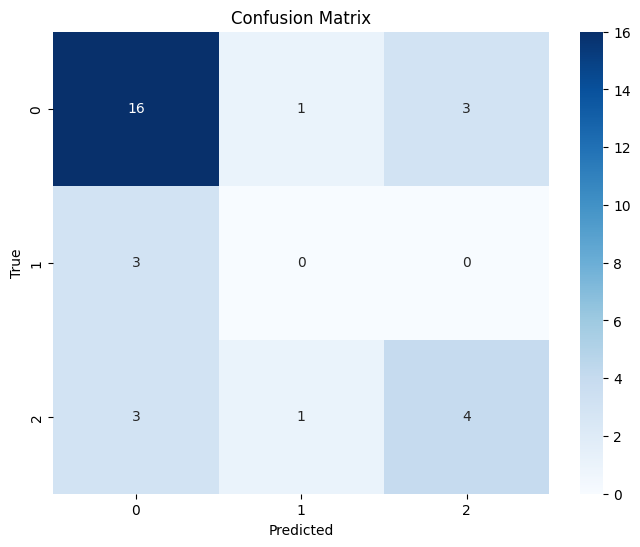

array([[16,  1,  3],
       [ 3,  0,  0],
       [ 3,  1,  4]])

In [67]:
evaluate_model(adaboost_classifier, val_x_embeddings, val_y_encoded)

In [68]:
from sklearn.utils import class_weight

classes = np.unique(train_y_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_y_encoded)
class_weights

array([0.51982379, 2.95      , 1.35632184])

In [69]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 0.5198237885462555, 1: 2.95, 2: 1.3563218390804597}

In [70]:
custom_class_weights = {
    0: 0.5,  # Antagonist
    1: 3.5,  # Innocent (increased from 2.95)
    2: 1.5   # Protagonist (slightly increased)
}

In [71]:
sample_weights = np.array([custom_class_weights[label] for label in train_y_encoded])

In [72]:
sample_weights

array([1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 3.5, 1.5, 1.5, 3.5, 0.5, 0.5,
       0.5, 3.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 1.5, 3.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5,
       3.5, 1.5, 1.5, 3.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 3.5, 0.5, 1.5,
       1.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 3.5, 0.5, 1.5, 0.5, 0.5, 3.5,
       1.5, 0.5, 3.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 3.5, 1.5, 0.5,
       1.5, 1.5, 0.5, 0.5, 3.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 3.5, 0.5,
       1.5, 1.5, 0.5, 3.5, 0.5, 3.5, 0.5, 3.5, 1.5, 3.5, 0.5, 1.5, 0.5,
       1.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5,
       3.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5, 1.5, 1.5,
       0.5, 1.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5,
       1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 1.5, 3.5, 0.5, 0.5, 1.5, 0.5, 3.5, 0.

In [73]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
get_cross_val_score(xgb_weighted, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.37979987 0.38187775 0.41911021]
Mean CV F1 Score: 0.3935959470612096


              precision    recall  f1-score    support
0              0.720000  0.900000  0.800000  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.750000  0.375000  0.500000   8.000000
accuracy       0.677419  0.677419  0.677419   0.677419
macro avg      0.490000  0.425000  0.433333  31.000000
weighted avg   0.658065  0.677419  0.645161  31.000000




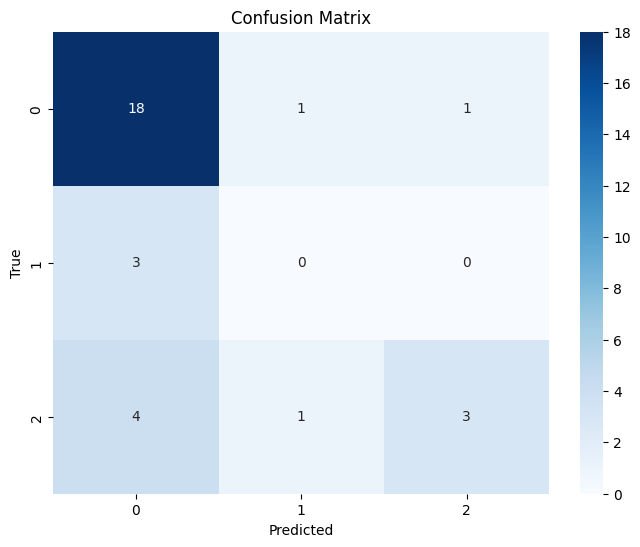

array([[18,  1,  1],
       [ 3,  0,  0],
       [ 4,  1,  3]])

In [74]:
xgb_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_x_embeddings, val_y_encoded)

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

decision_tree_weighted = DecisionTreeClassifier(max_depth=5, class_weight=custom_class_weights)
adaboost_weighted = AdaBoostClassifier(estimator=decision_tree_weighted, n_estimators=150, learning_rate=.1)
get_cross_val_score(adaboost_weighted, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.40998177 0.4208125  0.47566027]
Mean CV F1 Score: 0.4354848480322635


In [76]:
adaboost_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                  1: 3.5,
                                                                  2: 1.5},
                                                    max_depth=5),
                   learning_rate=0.1, n_estimators=150)

              precision    recall  f1-score    support
0              0.666667  0.800000  0.727273  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              1.000000  0.250000  0.400000   8.000000
accuracy       0.580645  0.580645  0.580645   0.580645
macro avg      0.555556  0.350000  0.375758  31.000000
weighted avg   0.688172  0.580645  0.572434  31.000000




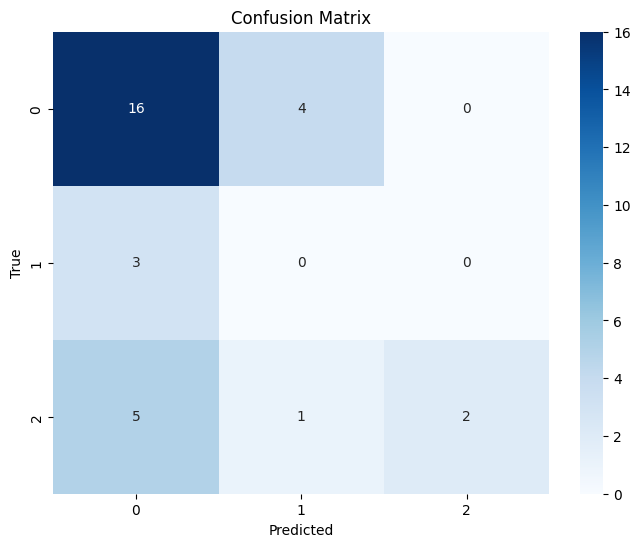

array([[16,  4,  0],
       [ 3,  0,  0],
       [ 5,  1,  2]])

In [77]:
evaluate_model(adaboost_weighted, val_x_embeddings, val_y_encoded)

In [78]:
from sklearn.svm import SVC

svm_classifier = SVC(C=10, gamma='scale', kernel='rbf') # attributes after running GridSearch
svm_classifier.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

SVC(C=10)

In [79]:
get_cross_val_score(svm_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.44583711 0.4109666  0.4457057 ]
Mean CV F1 Score: 0.4341698049345644


              precision    recall  f1-score    support
0              0.705882  0.600000  0.648649  20.000000
1              0.166667  0.333333  0.222222   3.000000
2              0.500000  0.500000  0.500000   8.000000
accuracy       0.548387  0.548387  0.548387   0.548387
macro avg      0.457516  0.477778  0.456957  31.000000
weighted avg   0.600569  0.548387  0.569021  31.000000




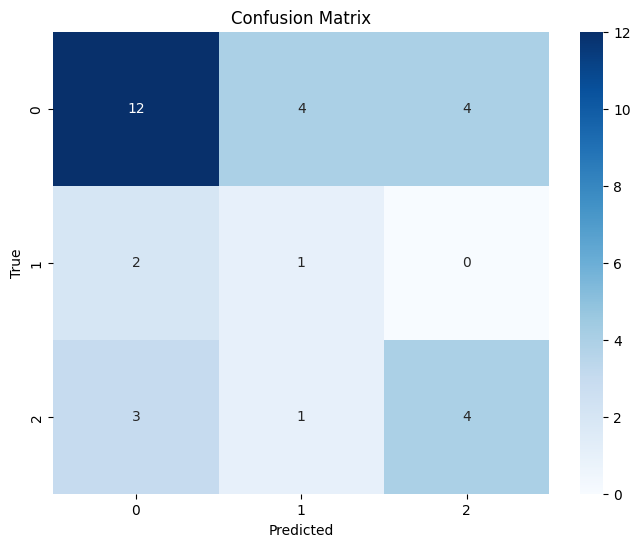

array([[12,  4,  4],
       [ 2,  1,  0],
       [ 3,  1,  4]])

In [80]:
evaluate_model(svm_classifier, val_x_embeddings, val_y_encoded)

In [81]:
classes = len(np.unique(train_y_encoded))

embedding_dim = train_x_embeddings.shape[1]

small_model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(embedding_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(classes, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [82]:
def compile_and_fit(x_train, y_train, model, optimizer=None, max_epochs=100, callbacks=[], lr=0.01, use_class_weights=False):
    if not optimizer:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        epochs=max_epochs,
        validation_data=(val_x_embeddings, val_y_encoded),
        callbacks=callbacks,
        verbose=2,
        class_weight=class_weights_dict if use_class_weights else None
    )
    return history

In [83]:
def plot_history(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def evaluate_mlp(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)

    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [84]:
hist_small = compile_and_fit(train_x_embeddings, train_y_encoded, small_model)

Epoch 1/100
12/12 - 0s - 25ms/step - accuracy: 0.6102 - loss: 0.9233 - val_accuracy: 0.6452 - val_loss: 0.8602
Epoch 2/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8741 - val_accuracy: 0.6452 - val_loss: 0.8515
Epoch 3/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8651 - val_accuracy: 0.6452 - val_loss: 0.8425
Epoch 4/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8415 - val_accuracy: 0.6452 - val_loss: 0.8319
Epoch 5/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8399 - val_accuracy: 0.6452 - val_loss: 0.8182
Epoch 6/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.8179 - val_accuracy: 0.6452 - val_loss: 0.8099
Epoch 7/100
12/12 - 0s - 1ms/step - accuracy: 0.6412 - loss: 0.7995 - val_accuracy: 0.6452 - val_loss: 0.8361
Epoch 8/100
12/12 - 0s - 1ms/step - accuracy: 0.6469 - loss: 0.8366 - val_accuracy: 0.6452 - val_loss: 0.8246
Epoch 9/100
12/12 - 0s - 1ms/step - accuracy: 0.6638 - loss: 0.7910 - val_accuracy: 0.6774 - val_loss: 0.8005
Epoch 10/

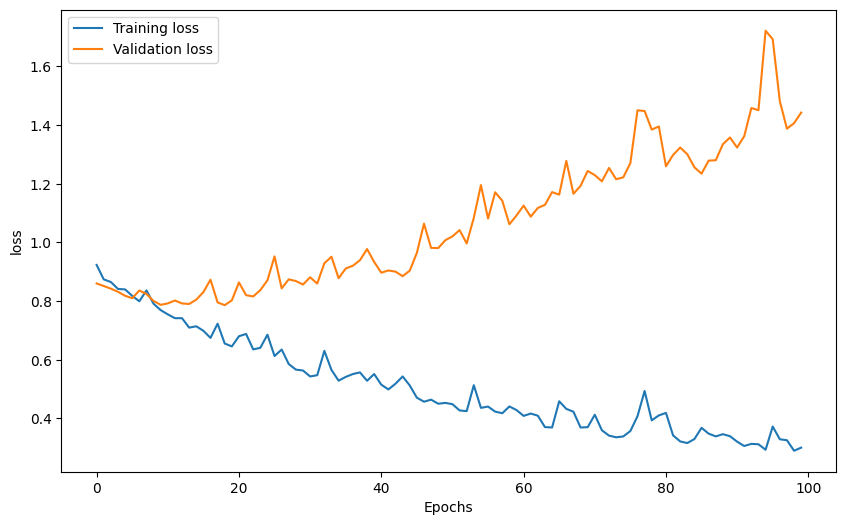

In [85]:
plot_history(hist_small)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.00      0.00      0.00         3
           2       0.60      0.38      0.46         8

    accuracy                           0.61        31
   macro avg       0.43      0.39      0.40        31
weighted avg       0.60      0.61      0.60        31

Confusion Matrix:


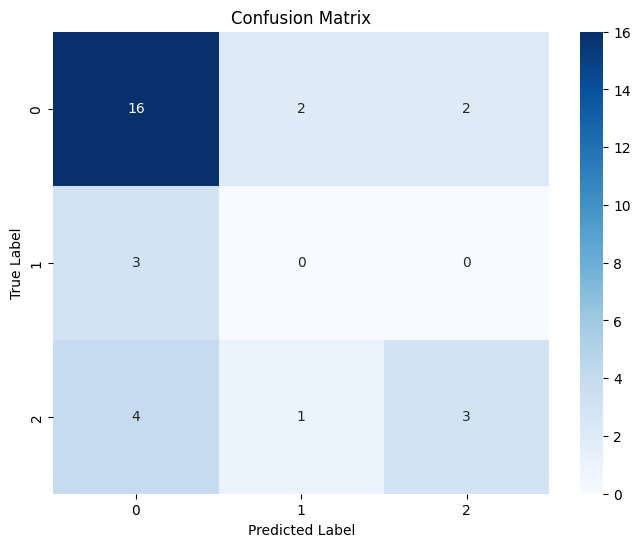

In [86]:
evaluate_mlp(small_model, val_x_embeddings, val_y_encoded)

In [87]:
import time

def pause():
    try:
      while True:
          time.sleep(60)
    except KeyboardInterrupt:
      print("Stopped")


In [88]:
# pause()

### Classifying sub-roles, from main roles

In [89]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context,main_role_encoded
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant],Putin honours army unit blamed for Bucha massa...,0
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian],a bullet in the head and chest as evidence of ...,2
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]",Russia has a clear plan to resolve the conflic...,0
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker],Russia has a clear plan to resolve the conflic...,2
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]",Russia has a clear plan to resolve the conflic...,0


In [90]:
dataset.drop(columns=['main_role_encoded'], inplace=True)

In [91]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant],Putin honours army unit blamed for Bucha massa...
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian],a bullet in the head and chest as evidence of ...
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]",Russia has a clear plan to resolve the conflic...
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker],Russia has a clear plan to resolve the conflic...
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]",Russia has a clear plan to resolve the conflic...


In [92]:
total_subroles = dataset['sub_roles'].explode()
unique_subroles = total_subroles.unique()

unique_subroles

array(['Tyrant', 'Guardian', 'Foreign Adversary', 'Peacemaker',
       'Instigator', 'Conspirator', 'Victim', 'Deceiver', 'Corrupt',
       'Exploited', 'Martyr', 'Scapegoat', 'Bigot', 'Rebel', 'Saboteur',
       'Terrorist', 'Incompetent', 'Traitor', 'Forgotten', 'Underdog',
       'Virtuous', 'Spy'], dtype=object)

In [93]:
len(unique_subroles)

22

In [94]:
total_subroles.value_counts()

sub_roles
Instigator           49
Guardian             40
Conspirator          38
Incompetent          36
Foreign Adversary    35
Victim               33
Tyrant               29
Deceiver             28
Saboteur             20
Virtuous             19
Corrupt              17
Peacemaker           15
Terrorist            14
Underdog             12
Martyr               11
Rebel                11
Bigot                 9
Scapegoat             8
Traitor               8
Exploited             6
Spy                   3
Forgotten             1
Name: count, dtype: int64

In [95]:
from sklearn.preprocessing import MultiLabelBinarizer

y = [['Victim', 'Exploited'], ['Exploited'], ['Victim'], ['Scapegoat', 'Exploited']]

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)
print(y_encoded)

[[1 0 1]
 [1 0 0]
 [0 0 1]
 [1 1 0]]


In [96]:
mlb = MultiLabelBinarizer()

sub_roles_binary = mlb.fit_transform(dataset['sub_roles'])
dataset['sub_roles_encoded'] = sub_roles_binary.tolist()

In [97]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context,sub_roles_encoded
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist,[Tyrant],Putin honours army unit blamed for Bucha massa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist,[Guardian],a bullet in the head and chest as evidence of ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist,"[Foreign Adversary, Tyrant]",Russia has a clear plan to resolve the conflic...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist,[Peacemaker],Russia has a clear plan to resolve the conflic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist,"[Instigator, Tyrant]",Russia has a clear plan to resolve the conflic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [98]:
dataset.iloc[3].sub_roles

['Peacemaker']

In [99]:
y_encoded[3]

array([1, 1, 0])

In [100]:
train_x_embeddings.shape

(354, 768)

In [101]:
val_x_embeddings.shape

(31, 768)